# Orientações do projeto

1. A solução criada nesse projeto deve ser disponibilizada em repositório git e disponibilizada em servidor de repositórios (Github (recomendado), Bitbucket ou Gitlab). O projeto deve obedecer o Framework TDSP da Microsoft. Todos os artefatos produzidos deverão conter informações referentes a esse projeto (não serão aceitos documentos vazios ou fora de contexto). Escreva o link para seu repositório.
   * Link para o repositório no GitHub: https://github.com/sergioopereira/EngenhariaMachineLearning 

2. Iremos desenvolver um preditor de arremessos usando duas abordagens (regressão e classificação) para prever se o "Black Mamba" (apelido de Kobe) acertou ou errou a cesta.
    Para começar o desenvolvimento, desenhe um diagrama que demonstra todas as etapas necessárias em um projeto de inteligência artificial desde a aquisição de dados, passando pela criação dos modelos, indo até a operação do modelo.
    <img src="https://docs.microsoft.com/pt-br/azure/architecture/data-science-process/media/lifecycle/tdsp-lifecycle2.png" width="800" height="597">

3. Descreva a importância de implementar pipelines de desenvolvimento e produção numa solução de aprendizado de máquinas.

4. Como as ferramentas Streamlit, MLFlow, PyCaret e Scikit-Learn auxiliam na construção dos pipelines descritos anteriormente? A resposta deve abranger os seguintes aspectos:
a. Rastreamento de experimentos;
b. Funções de treinamento;
c. Monitoramento da saúde do modelo;
d. Atualização de modelo;
e. Provisionamento (Deployment).

5. Com base no diagrama realizado na questão 2, aponte os artefatos que serão criados ao longo de um projeto. Para cada artefato, indique qual seu objetivo.

6. Implemente o pipeline de processamento de dados com o mlflow, rodada (run) com o nome "PreparacaoDados":
a. Os dados devem estar localizados em "/Data/kobe_dataset.csv"
b. Observe que há dados faltantes na base de dados! As linhas que possuem dados faltantes devem ser desconsideradas. Você também irá filtrar os dados onde o valor de shot_type for igual à 2PT Field Goal. Ainda, para esse exercício serão apenas consideradas as colunas: 
i. lat
ii. lng
iii. minutes remaining
iv. period
v. playoffs
vi. shot_distance
A variável shot_made_flag será seu alvo, onde 0 indica que Kobe errou e 1 que a cesta foi realizada. O dataset resultante será armazenado na pasta "/Data/processed/data_filtered.parquet". Ainda sobre essa seleção, qual a dimensão resultante do dataset?
c. Separe os dados em treino (80%) e teste (20 %) usando uma escolha aleatória e estratificada. Armazene os datasets resultantes em "/Data/operalization/base_{train|test}.parquet . Explique como a escolha de treino e teste afetam o resultado do modelo final. Quais estratégias ajudam a minimizar os efeitos de viés de dados.
d. Registre os parâmetros (% teste) e métricas (tamanho de cada base) no MlFlow

7. Implementar o pipeline de treinamento do modelo com o Mlflow usando o nome "Treinamento"
a. Com os dados separados para treinamento, treine um modelo com regressão logística do sklearn usando a biblioteca pyCaret.
b. Registre a função custo "log loss" usando a base de teste
c. Com os dados separados para treinamento, treine um modelo de classificação do sklearn usando a biblioteca pyCaret. A escolha do algoritmo de classificação é livre. Justifique sua escolha.
d. Registre a função custo "log loss" e F1_score para esse novo modelo

8. Registre o modelo de classificação e o disponibilize através do MLFlow através de API. Selecione agora os dados da base de dados original onde shot_type for igual à 3PT Field Goal (será uma nova base de dados) e através da biblioteca requests, aplique o modelo treinado. Publique uma tabela com os resultados obtidos e indique o novo log loss e f1_score.
a. O modelo é aderente a essa nova base? Justifique.
b. Descreva como podemos monitorar a saúde do modelo no cenário com e sem a disponibilidade da variável resposta para o modelo em operação
c. Descreva as estratégias reativa e preditiva de retreinamento para o modelo em operação.

9. Implemente um dashboard de monitoramento da operação usando Streamlit.

# Início da codificação

In [1]:
import os
import warnings
import sys

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn import linear_model, preprocessing, metrics, model_selection
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient

import seaborn as sn

if 'inline_rc' not in dir():
    inline_rc = dict(mpl.rcParams)

SEED = 10


# import logging
# logging.basicConfig(level=logging.WARN)
# logger = logging.getLogger(__name__)
np.random.seed(SEED)

In [2]:
# Reset do estilo de cores do matplotlib

mpl.rcParams.update(inline_rc)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
mpl.rc('font', **font)
lines = {'linewidth' : 3}
mpl.rc('lines', **lines)

# Configuração do preditor de arremessos

In [3]:
registered_model_name = 'modelo_arremesso' # Define o nome do modelo
min_precision = 0.5 # Define a precisão
model_version = -1 # recuperar a ultima versao
nexamples = 5

# Experimento de classificação de arremessos

In [4]:
# O componente MLflow Tracking é uma API e interface do usuário para registrar parâmetros, versões de código, métricas e arquivos de saída 
# ao executar seu código de aprendizado de máquina e para visualizar os resultados posteriormente.
# Muitos usuários também executam o MLflow em suas máquinas locais com um banco de dados compatível com SQLAlchemy : SQLite . 
# Nesse caso, os artefatos são armazenados no ./mlruns diretório local e as entidades MLflow são inseridas em um arquivo de banco de dados SQLite mlruns.db.

# Configura o MLflow para usar o sqlite como repositorio
mlflow.set_tracking_uri("sqlite:///mlruns.db")

experiment_name = 'Classificador de Arremessos' # Define o nome do experimento
experiment = mlflow.get_experiment_by_name(experiment_name) # Recuperar um experimento pelo nome do experimento da loja de back-end
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name) # Cria um experimento.
    experiment = mlflow.get_experiment(experiment_id) # Recuperar um experimento por experiment_id da loja de back-end
experiment_id = experiment.experiment_id

2022/09/04 20:17:32 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2022/09/04 20:17:32 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

# Leitura dos dados de arremessos 

In [5]:
# COLOCAR RUN DE LEITURA DE DADOS
# PARAMETROS: top_features,
# METRICS: SHAPE de cada base de dados
# ARTIFACTS: nenhum

top_features = ['lat','lon','minutes_remaining', 'playoffs','shot_distance']

# Inicia uma nova execução do MLflow, definindo-a como a execução ativa na qual as métricas e os parâmetros serão registrados. 
# O valor de retorno pode ser usado como gerenciador de contexto dentro de um withbloco; 
# caso contrário, você deve chamar end_run() para encerrar a execução atual.

with mlflow.start_run(
    experiment_id=experiment_id, 
    run_name = 'PreparacaoDados'):
    df_kobe = pd.read_csv('../Data/dataset_kobe.csv',sep=',')
    df_kobe = df_kobe.dropna() # remove a linha que possua alguma coluna vazia
    df_kobe['shot_made_flag'] = df_kobe['shot_made_flag'].astype(int) # converte a coluna em inteiro
    kobe_target_col = 'shot_made_flag' # Define a coluna alvo
    kobe_label_map = df_kobe[['shot_made_flag']].drop_duplicates() # 
    
    # Copia todos os dados do dataframe principal selecionando as top_features e o shot_type
    df_kobe = df_kobe[top_features + ['shot_type', kobe_target_col]].copy()

    # Copia os dados do dataframe com as top_features selecionando os casos onde shot_type for igual a "2PT Field Goal"
    # e remove a coluna shot_type
    data_kobe = df_kobe[df_kobe['shot_type'] == '2PT Field Goal'].copy().drop('shot_type', axis=1)
    
    # Separar parte do dataframe que contém shot_type for igual a "2PT Field Goal"para compor a base de operacao e treinamento
    data_kobe, data_operation, ytrain, ytest = model_selection.train_test_split(
        data_kobe, 
        data_kobe[kobe_target_col],
        test_size=0.2)
    data_kobe[kobe_target_col]     = ytrain
    data_operation[kobe_target_col] = ytest
    
    # Copia os dados do dataframe com as top_features selecionando os casos onde shot_type for igual a "3PT Field Goal"
    # e remove a coluna shot_type
    data_novelty = df_kobe[df_kobe['shot_type'] == '3PT Field Goal'].copy().drop('shot_type', axis=1)
    
    # grava os dataframes em arquivos parquet .
    data_novelty.to_parquet('modelo_arremesso_novidade.parquet')
    data_operation.to_parquet('modelo_arremesso_operacao.parquet')
    
    # to_parquet - Esta função grava o dataframe como um arquivo parquet.
    # O Apache Parquet fornece uma serialização colunar binária particionada para quadros de dados. 
    # Ele foi projetado para tornar a leitura e gravação de quadros de dados eficientes e para facilitar o compartilhamento de dados entre linguagens de análise de dados. 
    # O Parquet pode usar uma variedade de técnicas de compactação para reduzir o tamanho do arquivo o máximo possível, mantendo um bom desempenho de leitura.
    
    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("top_features", top_features)

    # LOG DE METRICAS GLOBAIS
    mlflow.log_metric("data_train", data_kobe.shape[0])
    mlflow.log_metric("data_operation", data_operation.shape[0])
    mlflow.log_metric("data_novelty", data_novelty.shape[0]) 

mlflow.end_run()

print('== Bases de Dados ==')
print(f'data_kobe {data_kobe.shape}')
print(f'data_operation {data_operation.shape}')
print(f'data_novelty {data_novelty.shape}')
print(f'Columns: {data_kobe.columns}')

== Bases de Dados ==
data_kobe (16228, 6)
data_operation (4057, 6)
data_novelty (5412, 6)
Columns: Index(['lat', 'lon', 'minutes_remaining', 'playoffs', 'shot_distance',
       'shot_made_flag'],
      dtype='object')


In [6]:
# mlflow ui --backend-store-uri sqlite:///mlruns.db -p 5002

# Treinamento do modelo

In [7]:
import pycaret.classification as pc # Essa função inicializa o ambiente de treinamento e cria o pipeline de transformação.
# COLOCAR RUN DE TREINAMENTO DE MODELOS
# PARAMETROS: fold_strategy, fold, model_name, registered_model_name, cross_validation
# METRICS: auto sklearn
# ARTIFACTS: plots

model_name = 'lr'
probability_threshold = 0.5
cross_validation = True
fold_strategy = 'stratifiedkfold',
fold = 10

# train/test
s = pc.setup(data = data_kobe, 
             numeric_features = top_features,
             target = kobe_target_col,
             train_size=0.7,
             silent = True,
             fold_strategy = 'stratifiedkfold',
             fold = fold,
             log_experiment = True, 
             experiment_name = experiment_name, 
             log_plots = True
            )
bestmodel = pc.create_model(model_name,
                            cross_validation = cross_validation, 
                            probability_threshold=probability_threshold)

# Log do run, e nao do modelo respectivo
classification_plots = [ 'auc','pr','confusion_matrix',
#                          'error', 'class_report', 
                        'threshold',
                         'learning','vc','feature',
                       ]
for plot_type in classification_plots:
    print('=> Aplicando plot ', plot_type)
    try:
        artifact = pc.plot_model(bestmodel, plot=plot_type, save=True, use_train_data=False)
        mlflow.log_artifact(artifact)
    except:
        print('=> Nao possivel plotar: ', plot_type )
        continue

pc.save_model(bestmodel, f'./{registered_model_name}') 
# Carrega novamente o pipeline + bestmodel
model_pipe = pc.load_model(f'./{registered_model_name}')


mlflow.end_run()

INFO  [logs] Saving 'Feature Importance.png'
INFO  [logs] Visual Rendered Successfully
INFO  [logs] plot_model() succesfully completed......................................
INFO  [logs] Initializing save_model()
INFO  [logs] save_model(model=CustomProbabilityThresholdClassifier(C=1.0, class_weight=None,
                                     classifier=LogisticRegression(C=1.0,
                                                                   class_weight=None,
                                                                   dual=False,
                                                                   fit_intercept=True,
                                                                   intercept_scaling=1,
                                                                   l1_ratio=None,
                                                                   max_iter=1000,
                                                                   multi_class='auto',
                              

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


# Avaliar a precisão mínima do modelo

In [8]:
# COLOCAR RUN APROVACAO DE MODELO
# PARAMETROS: min_precision
# METRICS: new_version, precision
# ARTIFACTS: None

with mlflow.start_run(experiment_id=experiment_id, run_name = 'AprovacaoModelo'):
    pred_holdout = pc.predict_model(bestmodel)
    pr = metrics.precision_score(pred_holdout[kobe_target_col], pred_holdout['Label'],) # Calcula a precisão
    # A precisão é a razão tp / (tp + fp) onde tp é o número de verdadeiros positivos e fp o número de falsos positivos. 
    # A precisão é intuitivamente a capacidade do classificador não rotular como positiva uma amostra que é negativa.
    # O melhor valor é 1 e o pior valor é 0.
    if pr > min_precision: # se o modelo atingiu a precisão mínima configurada
        print(f'=> Aceito o modelo com precisão {pr} (min: {min_precision})')
        pred_holdout.to_parquet('modelo_arremesso_teste.parquet') # Salva o modelo
        # Assinatura do Modelo Inferida pelo MLFlow
        model_features = list(data_kobe.drop(kobe_target_col, axis=1).columns) # armazena as features do modelo
        inf_signature = infer_signature(data_kobe[model_features], model_pipe.predict(data_kobe))
        # Exemplo de entrada para o MLmodel
        input_example = {x: data_kobe[x].values[:nexamples] for x in model_features}
        # Log do pipeline de modelagem do sklearn e registrar como uma nova versao
        mlflow.sklearn.log_model(
            sk_model=model_pipe,
            artifact_path="sklearn-model",
            registered_model_name=registered_model_name,
            signature = inf_signature,
            input_example = input_example
        )
        # Criacao do cliente do servico MLFlow e atualizacao versao modelo
        client = MlflowClient()
        if model_version == -1:
            model_version = client.get_latest_versions(registered_model_name)[-1].version
        # Registrar o modelo como staging
        client.transition_model_version_stage(
            name=registered_model_name,
            version=model_version, # Verificar com usuario qual versao
            stage="Staging"
        )
    else:
        print(f'=> Rejeitado o modelo com precisão {pr} (min: {min_precision})')

    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("precisao_minima", min_precision)

    # LOG DE METRICAS GLOBAIS
    mlflow.log_metric("new_version", model_version)
    mlflow.log_metric("precisao", pr)

mlflow.end_run()

INFO  [logs] Initializing predict_model()
INFO  [logs] predict_model(estimator=CustomProbabilityThresholdClassifier(C=1.0, class_weight=None,
                                     classifier=LogisticRegression(C=1.0,
                                                                   class_weight=None,
                                                                   dual=False,
                                                                   fit_intercept=True,
                                                                   intercept_scaling=1,
                                                                   l1_ratio=None,
                                                                   max_iter=1000,
                                                                   multi_class='auto',
                                                                   n_jobs=None,
                                                                   penalty='l2',
                                

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5765,0.5960,0.4743,0.5799,0.5218,0.1486,0.1510


=> Aceito o modelo com precisão 0.5798969072164949 (min: 0.5)


Successfully registered model 'modelo_arremesso'.
2022/09/04 20:18:15 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: modelo_arremesso, version 1
Created version '1' of model 'modelo_arremesso'.


# Serviço do Modelo 

In [15]:
# Para implantar um modelo associado a uma execução em um servidor de rastreamento, 
# defina a variável de ambiente MLFLOW_TRACKING_URI para a URL do servidor desejado.
import os
os.environ['MLFLOW_TRACKING_URI'] = 'sqlite:///mlruns.db' # Criando uma variável de ambiente

In [16]:
# Para implantar o servidor, execute
!mlflow models serve -m "models:/modelo_arremesso/Staging" --no-conda -p 5001 #

^C


In [10]:
## Comando Power Shell para criar variável de ambiente e implantar o modelo
# $env:MLFLOW_TRACKING_URI = 'sqlite:///mlruns.db'

# Comando Powershell para listar variáveis de ambiente
# dir env:

# Comando para publicar o modelo
# mlflow models serve -m "models:/modelo_arremesso/Staging" --no-conda -p 5001

# Operação Sistema preditor de arremessos

In [19]:
import requests
# Configura 
host = 'localhost'
port = '5001'
url = f'http://{host}:{port}/invocations'
headers = {'Content-Type': 'application/json',}

http_data = data_operation.drop(kobe_target_col,axis=1).to_json(orient='split') # Serializando os dados do dataframe para teste do modelo
r = requests.post(url=url, headers=headers, data=http_data) # Testando o modelo

data_operation.loc[:, 'operation_label'] = pd.read_json(r.text).values[:,0] # Recuperando o resultado do teste

data_operation.to_parquet('modelo_arremesso_operacao.parquet') # Gravando o dataframe de teste
data_operation[data_operation.operation_label == 1].sort_values('shot_distance', ascending=False).head(5)

,lat,lon,minutes_remaining,playoffs,shot_distance,shot_made_flag,operation_label
11796,33.9343,-118.3158,11,0,11,0,1
5237,33.9623,-118.3548,11,0,11,0,1
22100,33.9393,-118.2638,8,0,10,1,1
5988,33.9583,-118.3258,10,0,10,1,1
4239,34.0033,-118.3718,10,0,10,1,1


# Revalidacao de Amostras para Monitoramento

In [20]:
# COLOCAR RUN REVALIDACAO
# PARAMETROS: min_samples_control
# METRICS: matriz de confusao
# ARTIFACTS:


# Utilizacao da amostra de controle, que teria sido reavaliada por especialistas
min_samples_control = 150

with mlflow.start_run(experiment_id=experiment_id, run_name = 'RevalidacaoOperacao'):

    data_operation = pd.read_parquet('modelo_arremesso_operacao.parquet')

    data_control = data_operation.sample(min_samples_control, random_state=SEED)
    data_control.to_parquet('modelo_arremesso_controle.parquet')

    print('== DADOS DE CONTROLE ==')
    print(metrics.classification_report(data_control[kobe_target_col], data_control['operation_label']))
    
    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("min_samples_control", min_samples_control)

    # LOG DE METRICAS GLOBAIS
    cm = metrics.confusion_matrix(data_control[kobe_target_col], data_control['operation_label'])
    specificity = cm[0,0] / cm.sum(axis=1)[0]
    sensibility = cm[1,1] / cm.sum(axis=1)[1]
    precision   = cm[1,1] / cm.sum(axis=0)[1]
    mlflow.log_metric("Especificidade", specificity)
    mlflow.log_metric("Sensibilidade", sensibility)
    mlflow.log_metric("Precisao", precision)

mlflow.end_run()

== DADOS DE CONTROLE ==
              precision    recall  f1-score   support

           0       0.52      0.68      0.59        69
           1       0.63      0.47      0.54        81

    accuracy                           0.57       150
   macro avg       0.58      0.58      0.57       150
weighted avg       0.58      0.57      0.56       150



## Alarme de Desvio 

In [21]:
# reset matplotlib

mpl.rcParams.update(inline_rc)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
mpl.rc('font', **font)
lines = {'linewidth' : 3}
mpl.rc('lines', **lines)

def data_drift_alarm(var_name, dev_data, data_test, data_control):    
    sn.kdeplot(dev_data[var_name], label='Desenvolvimento')
    sn.kdeplot(data_test[var_name], label='Teste')
    sn.kdeplot(data_control[var_name], label='Monitoramento')
    plt.grid()
    plt.legend(loc='best')
    plt.title(f'Distribuição Variável {var_name}')
    plt.ylabel('Densidade')
    plt.xlabel(f'Unidade de {var_name}')
    plt.tight_layout()

## Alarme de Retreinamento

In [22]:
def alarm(data_monitoring, testset, min_eff_alarm):
    cm = metrics.confusion_matrix(data_monitoring[kobe_target_col], data_monitoring['operation_label'])
    specificity_m = cm[0,0] / cm.sum(axis=1)[0]
    sensibility_m = cm[1,1] / cm.sum(axis=1)[1]
    precision_m   = cm[1,1] / cm.sum(axis=0)[1]

    cm = metrics.confusion_matrix(testset[kobe_target_col], testset['Label'])
    specificity_t = cm[0,0] / cm.sum(axis=1)[0]
    sensibility_t = cm[1,1] / cm.sum(axis=1)[1]
    precision_t   = cm[1,1] / cm.sum(axis=0)[1]

    retrain = False
    for name, metric_m, metric_t in zip(['especificidade', 'sensibilidade', 'precisao'],
                                        [specificity_m, sensibility_m, precision_m],
                                        [specificity_t, sensibility_t, precision_t]):
        
        print(f'\t=> {name} de teste {metric_t} e de controle {metric_m}')
        if (metric_t-metric_m)/metric_t > min_eff_alarm:
            print(f'\t=> MODELO OPERANDO FORA DO ESPERADO')
            retrain = True
        else:
            print(f'\t=> MODELO OPERANDO DENTRO DO ESPERADO')
           
        
    return (retrain, [specificity_m, sensibility_m, precision_m],
                                        [specificity_t, sensibility_t, precision_t] ) 

### Monitoramento Base Operacao 

In [23]:
# COLOCAR RUN MONITORAMENTO OPERACAO
# PARAMETROS: min_eff_alarm
# METRICS: metricas avaliadas e de referencia
# ARTIFACTS:

print('== ALARME DE RETREINAMENTO - BASE CONTROLE ==')
# 10% de desvio aceitavel na metrica. Deve ser estimado pelo conjunto de validacao cruzada. 
min_eff_alarm = 0.1 

with mlflow.start_run(experiment_id=experiment_id, run_name = 'MonitoramentoOperacao'):
    data_control = pd.read_parquet('modelo_arremesso_controle.parquet')
    
    (retrain, [specificity_m, sensibility_m, precision_m],
              [specificity_t, sensibility_t, precision_t] ) = alarm(data_control, pred_holdout, min_eff_alarm)
    if retrain:
        print('==> RETREINAMENTO NECESSARIO')
    else:
        print('==> RETREINAMENTO NAO NECESSARIO')
    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("min_eff_alarm", min_eff_alarm)

    # LOG DE METRICAS GLOBAIS
    mlflow.log_metric("Alarme Retreino", float(retrain))
    mlflow.log_metric("Especificidade Controle", specificity_m)
    mlflow.log_metric("Sensibilidade Controle", sensibility_m)
    mlflow.log_metric("Precisao Controle", precision_m)
    mlflow.log_metric("Especificidade Teste", specificity_t)
    mlflow.log_metric("Sensibilidade Teste", sensibility_t)
    mlflow.log_metric("Precisao Teste", precision_t)
    
    # LOG ARTEFATO
    var_name = 'volatile acidity' # 'alcohol'
    data_drift_alarm(var_name, data_kobe, pred_holdout, data_control)
    plot_path = f'monitor_datadrift_{var_name}.png'
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)
    

mlflow.end_run()  

== ALARME DE RETREINAMENTO - BASE CONTROLE ==
	=> especificidade de teste 0.6736083299959952 e de controle 0.6811594202898551
	=> MODELO OPERANDO DENTRO DO ESPERADO
	=> sensibilidade de teste 0.474283305227656 e de controle 0.4691358024691358
	=> MODELO OPERANDO DENTRO DO ESPERADO
	=> precisao de teste 0.5798969072164949 e de controle 0.6333333333333333
	=> MODELO OPERANDO DENTRO DO ESPERADO
==> RETREINAMENTO NAO NECESSARIO


KeyError: 'volatile acidity'

# Operação Aplicação Python

### Monitoramento Base de Novidade

== ALARME DE RETREINAMENTO - BASE NOVIDADE ==
	=> especificidade de teste 0.6736083299959952 e de controle 0.9997245179063361
	=> MODELO OPERANDO DENTRO DO ESPERADO
	=> sensibilidade de teste 0.474283305227656 e de controle 0.0
	=> MODELO OPERANDO FORA DO ESPERADO
	=> precisao de teste 0.5798969072164949 e de controle 0.0
	=> MODELO OPERANDO FORA DO ESPERADO
==> RETREINAMENTO NECESSARIO


WARNI [matplotlib.font_manager] findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
WARNI [matplotlib.font_manager] findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


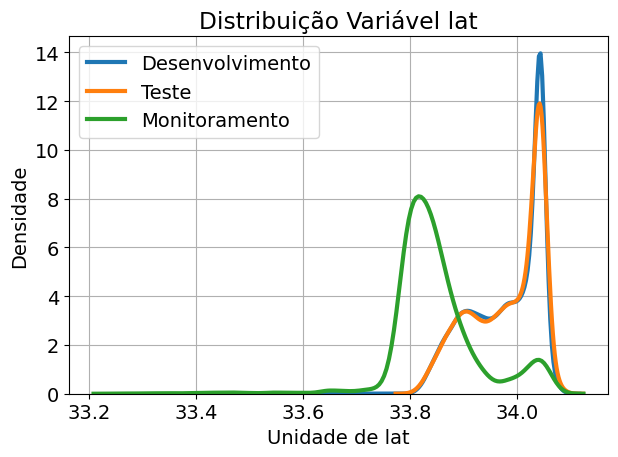

In [25]:
# COLOCAR RUN MONITORAMENTO NOVIDADE
# PARAMETROS: min_eff_alarm
# METRICS: metricas avaliadas e de referencia
# ARTIFACTS:

print('== ALARME DE RETREINAMENTO - BASE NOVIDADE ==')
# 10% de desvio aceitavel na metrica. Deve ser estimado pelo conjunto de validacao cruzada. 
min_eff_alarm = 0.1 

with mlflow.start_run(experiment_id=experiment_id, run_name = 'MonitoramentoNovidade'):

    model_uri = f"models:/modelo_arremesso/Staging"
    loaded_model = mlflow.sklearn.load_model(model_uri)
    data_novelty = pd.read_parquet('modelo_arremesso_novidade.parquet')
    data_novelty.loc[:, 'operation_label'] = loaded_model.predict(data_novelty.drop(kobe_target_col,axis=1))
    
    (retrain, [specificity_m, sensibility_m, precision_m],
              [specificity_t, sensibility_t, precision_t] ) = alarm(data_novelty, pred_holdout, min_eff_alarm)
    if retrain:
        print('==> RETREINAMENTO NECESSARIO')
    else:
        print('==> RETREINAMENTO NAO NECESSARIO')
    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("min_eff_alarm", min_eff_alarm)

    # LOG DE METRICAS GLOBAIS
    mlflow.log_metric("Alarme Retreino", float(retrain))
    mlflow.log_metric("Especificidade Controle", specificity_m)
    mlflow.log_metric("Sensibilidade Controle", sensibility_m)
    mlflow.log_metric("Precisao Controle", precision_m)
    mlflow.log_metric("Especificidade Teste", specificity_t)
    mlflow.log_metric("Sensibilidade Teste", sensibility_t)
    mlflow.log_metric("Precisao Teste", precision_t)
    # LOG ARTEFATO
    var_name = 'lat' # Latitude
    data_drift_alarm(var_name, data_kobe, pred_holdout, data_novelty)
    plot_path = f'novidade_datadrift_{var_name}.png'
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)

mlflow.end_run() 